In [48]:
from dipy.viz import fvtk
from dipy.core.gradients import gradient_table
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from dipy.reconst import mapmri
import mapmri.mapmri as mp
import datetime

reload(mp)

<module 'mapmri.mapmri' from 'mapmri/mapmri.pyc'>

In [49]:
%pylab inline
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import img_utils
import seaborn as sns
import utils.math_utils as mu
import nibabel as nib


def load_subject_medium(index, numbers, bval=None, bvalpos=None ):
    subject = str(numbers[index])
    folder = './HCP/'+subject+'/'
    bvals = np.loadtxt(folder+ 'bvals_'+subject)
    bvecs = np.loadtxt(folder+'bvecs_'+subject)
    
    if bvalpos is not None:
        img = nib.load(folder+ 'data_medium40g_12x12x12x40_'+subject+'_b'+str(bval)+'.nii.gz')
        bsize=min(len(bvalpos), img.shape[3])
        gtab = gradient_table(bvals=bvals[bvalpos[:bsize]], bvecs=bvecs[:,bvalpos[:bsize]])
    else:
        img = nib.load(folder+ 'data_medium40g_12x12x12x40_'+subject+'.nii.gz')
        bsize = img.shape[3]
        gtab = gradient_table(bvals=bvals[:bsize], bvecs=bvecs[:,:bsize])
    return img, gtab


def load_subject_small(index, numbers, bval=None, bvalpos=None ):
    subject = str(numbers[index])
    folder = './HCP/'+subject+'/'
    bvals = np.loadtxt(folder+ 'bvals_'+subject)
    bvecs = np.loadtxt(folder+'bvecs_'+subject)
    
    if bvalpos is not None:
        img = nib.load(folder+ 'data_small_12x12x12x6_'+subject+'_b'+str(bval)+'.nii.gz')
        bsize=min(len(bvalpos), img.shape[3])
        gtab = gradient_table(bvals=bvals[bvalpos[:bsize]], bvecs=bvecs[:,bvalpos[:bsize]])
    else:
        img = nib.load(folder+ 'data_small_12x12x12x6_'+subject+'.nii.gz')
        bsize = img.shape[3]
        gtab = gradient_table(bvals=bvals[:bsize], bvecs=bvecs[:,:bsize])
    return img, gtab



def mm(A):
    return (int(A.min()), int(A.max()))


Populating the interactive namespace from numpy and matplotlib


## Loading subjects (12, 12, 12) 16 b-vals, 40 gradients

(12, 12, 12, 6) (12, 12, 12, 40) bvals= [1985.0, 3010.0, 995.0, 5.0, 1990.0, 1000.0, 2985.0, 1995.0, 1005.0, 2990.0, 2000.0, 2995.0, 2005.0, 3000.0, 2010.0, 3005.0, 990.0]


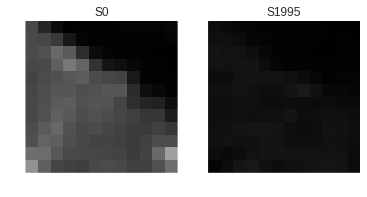

In [50]:
subjects = [100307, 100408, 180129, 180432, 180836, 180937]
bvals2000pos = [18, 27, 69, 75, 101, 107]
bvals5pos = [0,16,32,48,64,80,95,112,128,144,160,176,191,208,224,240,256,272]

# Esto es para quedame con la gtab que es igua a todos
img, gtab = load_subject_medium(2 , subjects)
img_s0, gtab_s0 = load_subject_small(2, subjects, bval=5, bvalpos=bvals5pos[0:6])

i_hr=img.get_data()
S0 = img_s0.get_data()

b=2
img_utils._isc(S0, i_hr, b=b, vmin=S0.min(),  vmax=S0.max(), titles=['S0', 'S'+str(int(gtab.bvals[b]))])
print S0.shape, i_hr.shape, 'bvals=',list(set(gtab.bvals))

In [51]:

def getM(radial_order, mu, gtab, tau):
    r'''Recovers the reconstructed signal for any qvalue array or
        gradient table.
        '''
    qvals = np.sqrt(gtab.bvals / tau) / (2 * np.pi)
    q = qvals[:, None] * gtab.bvecs
    M = mp.mapmri_isotropic_phi_matrix(radial_order, mu[0], q)
    return  M


"""
Asi tal cual me sugerio Rutger que invoque a los parametros
"""
reload(mp)
radial_order = 4
#Fiteo el model
map_model = mp.MapmriModel(gtab,
                            radial_order=radial_order,
                            laplacian_regularization=True,
                            laplacian_weighting=0.2,
                            anisotropic_scaling=False,
                            dti_scale_estimation=False)
# Fiteo la data
map_model_fit = map_model.fit(i_hr)
tau = map_model.tau
mu = map_model_fit.mu[0,0,0]
print 'mu.shape', mu.shape
Morig = getM(radial_order, mu, gtab, tau)
Corig = map_model_fit.mapmri_coeff
print 'Corig.shape', Corig.shape, 'norm1', cvx.norm1(Corig.flatten()).value, '|c|', np.linalg.norm(Corig)
print 'Morig.shape', Morig.shape
print 'Tau', tau



mu.shape (3,)
Corig.shape (12, 12, 12, 22) norm1 4067.78870578 |c| 65.2069363251
Morig.shape (40, 22)
Tau 0.0253302959106


In [52]:
reload(mp)

def mypredictBKP(gtab, C, M, tau):
    qvals = np.sqrt(gtab.bvals / tau) / (2 * np.pi)
    q = qvals[:, None] * gtab.bvecs
    Nb, Nc = M.shape 
    Nx, Ny, Nz, Nc = C.shape 
    vhr = Nx*Ny*Nz
    vhrb = vhr*Nb
    Cvec = C.reshape((Nx*Ny*Nz, Nc), order='F')
    E = np.dot(M, Cvec.T).T.reshape((Nx, Ny, Nz,Nb), order='F')
    return E

def mypredict(gtab, C_or_Cvec, M, tau):
    is_cvxpy = isinstance(C_or_Cvec, cvx.Variable)
    qvals = np.sqrt(gtab.bvals / tau) / (2 * np.pi)
    q = qvals[:, None] * gtab.bvecs
    Nb, Nc = M.shape
    if is_cvxpy :
        vhr, Nc = C_or_Cvec.size
    else:
        Nx, Ny, Nz, Nc = C_or_Cvec.shape
        vhr = Nx*Ny*Nz
    vhrb = vhr*Nb
    
    Cvec = C_or_Cvec
    if not is_cvxpy :
        Cvec = Cvec.reshape((Nx*Ny*Nz, Nc), order='F')
        
    #E = np.dot(M, Cvec.T).T
    
    if is_cvxpy :
        E = (M * Cvec.T)
    else:
        E = np.dot(M, Cvec.T).T
        
    if not is_cvxpy :
        E = E.reshape((Nx, Ny, Nz,Nb), order='F')
    #else:
    #    E = E.reshape(-1, order='F')
        
    return E

# Predict con el C de rutger
Eq_reconst_orig = mypredict(gtab, Corig, Morig, tau)

for b in xrange(Eq_reconst_orig.shape[3]):
    Eq_reconst_orig[:,:,:,b] = Eq_reconst_orig[:,:,:,b]*S0.mean(axis=3)

print 'Eq_recons desp div S0 max min', mm(Eq_reconst_orig)

Eq_recons desp div S0 max min (-173, 16175)


# Compare predit and signal

(0, 1522)
Error relativo max,min u std (0, 95) 0 0


<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

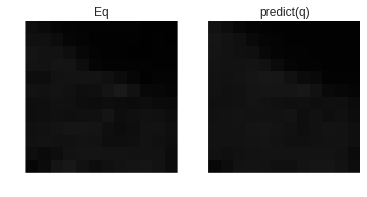

In [53]:
err_mapmrifit = np.abs(Eq_reconst_orig - i_hr)
err_rel_mapmrifit = np.divide(err_mapmrifit, i_hr+1)#para q no de infinito

print mm(err_mapmrifit) 
print 'Error relativo max,min u std', mm(err_rel_mapmrifit), int(err_rel_mapmrifit.mean()), \
                                      int(np.std(err_rel_mapmrifit)) 

img_utils._isc(i_hr, Eq_reconst_orig, b=2, vmin=0, vmax=i_hr.max(), titles=['Eq', 'predict(q)'])


## Calculo C con optimizacion

In [54]:
import cvxpy as cvx

def define_opt_problem(i_hr, gtab, M, tau, Nc, S0):
    Nx, Ny, Nz, bval = i_hr.shape
    vhr = Nx*Ny*Nz
    vhrb = vhr*bval
    
    # Image to fit
    Yhr = cvx.Parameter(vhrb, 1)
    Yhr.value = i_hr.reshape(-1, order='F')

    ## MAPL params
    #cvxM = cvx.Parameter(bval, Nc)
    #cvxM.value = M
    cvxM = cvx.Constant(M)
    
    #tau = mapl_parameters(gtab)
    cvxC = cvx.Variable(vhr, Nc)

    #if S0 is None:
    #    cvxS0 = cvx.Parameter(vhr)
    #    cvxS0.value = np.ones((vhr, 1), dtype='float')*100
    #else:
    #    cvxS0 = cvx.Parameter(vhr)
    #    cvxS0.value = S0.reshape(-1, order='F')
    
    # cvxE:(Nb,vhr)
    cvxE = mypredict(gtab, cvxC, M, tau)
    print 'E.size', cvxE.size
    
    alpha = cvx.Parameter(value=.62, sign='positive')
    
    # En el codigo original las var si se pueden resizear
    YhrMap = cvx.Parameter(vhr,bval)
    YhrMap = i_hr.reshape((vhr,bval), order='F').T
    
    ## objective
    norm1 = cvx.norm1(cvxC)
    obj = cvx.Minimize(cvx.sum_squares(cvxE-YhrMap) + alpha*norm1)

    ## some constraints
    # pos_cons =[ cvxM*cvxC[i,:].T >= 0  for i in xrange(vhr) ]
    # max_cons =[ cvxM*cvxC[i,:].T*cvxS0[i] <= i_hr.max() for i in xrange(vhr) ]

    prob = cvx.Problem(obj)#

    print 'Problema definido Definido ', datetime.datetime.now()
    
    return prob, cvxM, cvxC,  norm1

In [55]:
Nb=22 # 4 --> 22, 6 --> 50
Nx, Ny, Nz, bval = i_hr.shape
vhr = Nx*Ny*Nz
vhrb = vhr*bval

prob, cvxM, cvxC, norm1 = define_opt_problem(i_hr, gtab, Morig, tau, Nb, S0.mean(axis=3))

# Solve problem
start_time = time.time()
res = prob.solve(solver='SCS', max_iters=1000, eps=1.00e-02, verbose=True)  # Returns the optimal value.
seg = time.time() - start_time
minutes = int(seg / 60)
print("--- time of optimization : %d' %d'' ---" % (minutes , seg%60))
print "--- status:", prob.status, "optimal value", prob.value
print 

# Change dimension of result representation
if cvxC.value is None :
    print 'FRECONSTRUCTION FAIL :('

C = np.asarray(cvxC.value, dtype='float32').reshape((Nx, Ny, Nz,Nb), order='F')
    
print '|C| =', np.linalg.norm(C)
print 'minimzation op_val =', prob.value

E.size (40, 1728)
Problema definido Definido  2016-08-30 10:21:29.777750
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1672706, CG tol ~ 1/iter^(2.00)
eps = 1.00e-02, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
Variables n = 76033, constraints m = 145154
Cones:	linear vars: 76032
	soc vars: 69122, soc blks: 1
Setup time: 9.23e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 8.80e+00  1.47e+01  1.00e+00 -2.24e+08  1.04e+08  4.69e-08  1.38e-01 
   100| 6.37e-03  6.60e-03  2.01e-02  5.84e+06  6.08e+06  3.20e-09  4.76e+00 
   200| 4.76e-03  5.27e-03

(0, 986)
Error relativo max,min u std (0, 196) 0 0
norm1(cvxC) 7988114.48168


((-173, 16175), (-309, 16211))

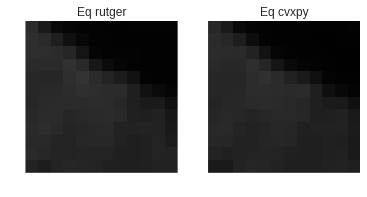

In [56]:
# Predict con el C de rutger
Eq_reconst = mypredict(gtab, C, Morig, tau)

"""ACORDATE!!!
la que te da cvxpy ya viene multiplicada por S0 ( es decir es la senial no la atenuacion)
la de rutger te da la atenuacion 
"""
#for b in xrange(Eq_reconst.shape[3]):
#    Eq_reconst[:,:,:,b] = Eq_reconst[:,:,:,b]*S0.mean(axis=3)


err = np.abs(Eq_reconst - i_hr)
err_rel = np.divide(err, i_hr+1)#para q no de infinito

print mm(err) 
print 'Error relativo max,min u std', mm(err_rel), int(err_rel.mean()), \
                                      int(np.std(err_rel)) 

    
print 'norm1(cvxC)', norm1.value
img_utils._isc(Eq_reconst_orig, Eq_reconst, b=b, vmin=0, vmax=Eq_reconst.max(), titles=['Eq rutger', 'Eq cvxpy'])
mm(Eq_reconst_orig), mm(Eq_reconst)

((0, 16743), (-309, 16211))

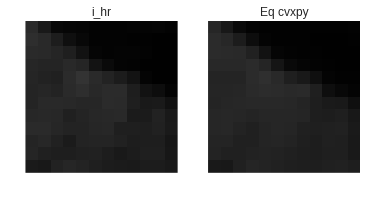

In [57]:
img_utils._isc(i_hr, Eq_reconst,b=b, vmin=0, vmax=i_hr.max(), titles=['i_hr', 'Eq cvxpy'])
mm(i_hr), mm(Eq_reconst)

## Compare C 

In [59]:
dif_c = np.abs(C - map_model_fit.mapmri_coeff)
ecm_c = ((C - map_model_fit.mapmri_coeff)**2).mean()

print '|dif_c| min/max:', int(np.linalg.norm(dif_c)), mm(dif_c) 
print '|C| |Corig|:',  int(np.linalg.norm(C)), int(np.linalg.norm(map_model_fit.mapmri_coeff)), cvx.norm1(C.flatten()).value
print 'ecm :', ecm_c

|dif_c| min/max: 174436 (0, 6682)
|C| |Corig|: 174473 65 7988114.47694
ecm : 800400.755289


(array([   403.,   8563.,  26623.,    576.,    179.,    167.,    136.,
           273.,    998.,     98.]),
 array([-1375.03234863,  -712.08585205,   -49.13935547,   613.80714111,
         1276.7536377 ,  1939.70013428,  2602.64663086,  3265.59312744,
         3928.53962402,  4591.48612061,  5254.43261719]),
 <a list of 10 Patch objects>)

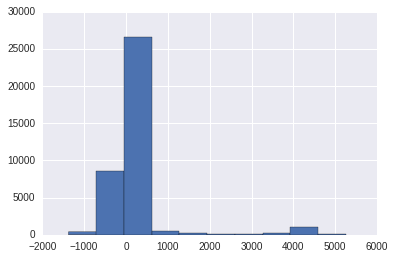

In [132]:
hist(C.flatten())

(array([  2.00000000e+00,   2.00000000e+01,   1.55000000e+02,
          2.77000000e+02,   3.57770000e+04,   1.27200000e+03,
          3.62000000e+02,   1.32000000e+02,   1.70000000e+01,
          2.00000000e+00]),
 array([-3.04472989, -2.34913615, -1.65354242, -0.95794869, -0.26235496,
         0.43323877,  1.1288325 ,  1.82442623,  2.52001996,  3.21561369,
         3.91120743]),
 <a list of 10 Patch objects>)

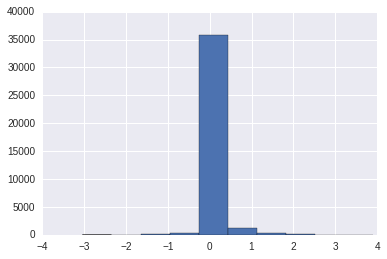

In [120]:
hist( map_model_fit.mapmri_coeff.flatten())

# Compare Ms


In [7]:
print M.shape, Morig.shape

mses = []
for i in xrange(12):
    for j in xrange(12):
        for k in xrange(12):
            ((Morig[i,j,k]-M)**2).mean()
            
print len(mses), sum(mses), sum(mses)/len(mses)
hist((Morig[0,1,0]-M).flatten())


NameError: name 'M' is not defined

In [26]:
mses = ((Eq_reconst - Eq_reconst_orig)**2)/2
print mm(mses), mses.shape
res = img_utils._isc3(Eq_reconst,Eq_reconst_orig, mses, vmax=Eq_reconst.max(), titles=['recons', 'orig', 'mse'])
res[0].clim(mm(mses))

NameError: name 'Eq_reconst' is not defined

(array([ 43406.,  21391.,   1359.,   1428.,    405.,    312.,    330.,
           225.,    201.,     63.]),
 array([  -136.37439124,   1219.30785661,   2574.99010445,   3930.67235229,
          5286.35460013,   6642.03684797,   7997.71909581,   9353.40134366,
         10709.0835915 ,  12064.76583934,  13420.44808718]),
 <a list of 10 Patch objects>)

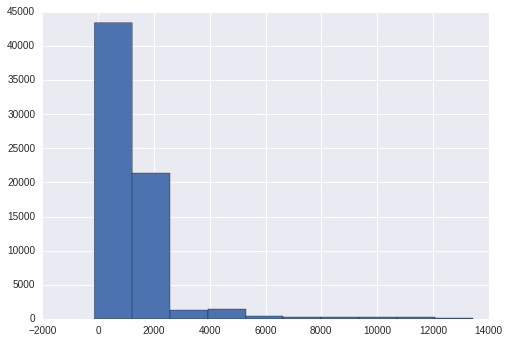

In [31]:
hist(Eq_reconst_orig.flatten())

(array([  4.48620000e+04,   1.41090000e+04,   6.37000000e+03,
          1.92900000e+03,   8.01000000e+02,   5.45000000e+02,
          3.95000000e+02,   9.50000000e+01,   9.00000000e+00,
          5.00000000e+00]),
 array([  -252.79449463,   1347.48573608,   2947.7659668 ,   4548.04619751,
          6148.32642822,   7748.60665894,   9348.88688965,  10949.16712036,
         12549.44735107,  14149.72758179,  15750.0078125 ]),
 <a list of 10 Patch objects>)

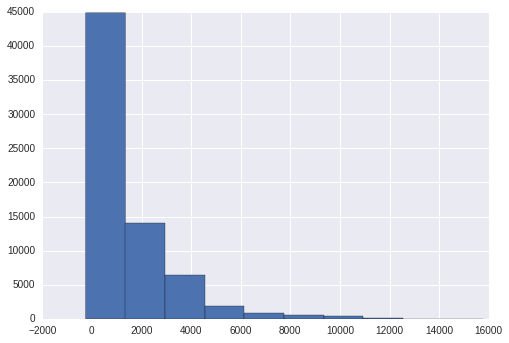

In [32]:
hist(Eq_reconst.flatten())

# DTI 3d (intento)

In [ ]:

Yhr_vxb = cvx.Parameter(vhr,Nb)
Yhr_vxb.value = i_hr.reshape(-1, order='F').reshape(vhr,Nb)

## Dti params
Nb = gtab.bvals.shape[0]
cvBvals = cvx.Parameter(Nb)
cvBvals.value = gtab.bvals
cvBvecs = cvx.Parameter(Nb,3)
cvBvecs.value = gtab.bvecs

Ds = [ cvx.Semidef(3) for i in xrange(vhr)]
cvB = cvx.diag(cvBvals)*cvBvecs # (bval, 3)

BDBs = [cvx.diag(cvB*Ds[i]*cvB.T) for i in xrange(vhr)]

#constraint = [cvB*Ds[i]*cvB.T >= 0 for i in xrange(vhr)]

print 'BDBs', BDBs[0].size

#v = cvx.Variable()#,0]
#cvx.exp(v)

print BDBs[0][1].size

# Opcion B suma de cuadrados por cada voxel
#dti_list = []
#for i in xrange(vhr):
    #Yi = Yhr[i:vhrb:vhr]
    #dti_list = [ (cvx.inv_pos(cvx.exp(BDBs[i][b])) - Yi[b]) for b in xrange(bval)]
    #dti_list = [ BDBs[i][b] + cvx.log(Yi[b]) for b in xrange(bval)]
#dti = sum(dti_list, contraint)
        
prob = cvx.Problem(cvx.Minimize(cvx.sum_squares(BDBs[i][b] + cvx.log(Yhr_vxb))))
print 'Problema definido Definido ', datetime.datetime.now()


solvers = ["SCS"
    "GLPK",
        "GLPK_MI",
        "Elemental",
        "ECOS" ,
        "ECOS_BB",
        "GUROBI",
        "MOSEK",
        "CVXOPT",
        "SCS"]

# Solve problem
for solver in solvers :
    start_time = time.time()
    resolvio = True
    try:
        res = prob.solve(solver=solver, max_iters=1000, eps=1.00e-02, verbose=True)  # Returns the optimal value.
    except:
        resolvio = False
    seg = time.time() - start_time
    minutes = int(seg / 60)
    if resolvio :
        print("---[%s] time of optimization : %d' %d'' ---" % (solver, minutes , seg%60))
        print "--- status:", prob.status, "optimal value", prob.value
    else:
        print solver, 'fail'
    print 

# Change dimension of result representation
if cvxC.value is None :
    print 'FRECONSTRUCTION FAIL :('

D = np.asarray(Ds.value, dtype='float32').reshape((Nx, Ny, Nz,3, 3), order='F')
    


<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

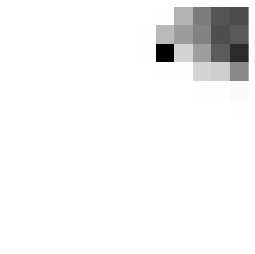

In [174]:

#tenmodel = dti.TensorModel(gtab)
#tenfit = tenmodel.fit(i_hr)

img_utils._is(i_hr)